# In this notebook...

In this notebook we will:

- Overview the end-to-end machine learning process
- Explore a telecom dataset and create a model to predict customer churn
- Deploy a Flask API on PythonAnywhere
- Deploy a React application on Netlify

# Requirements

To follow along with this notebook, make sure you

- Have Jupyter
- Have an environment with the following installed:  
  - Pandas
  - Sklearn
  - Flask
  - NumPy
  - statsmodels
  - Matplotlib

- Have JavaScript installed
- Have Node installed
- Have React installed
- Have cURL installed

# Introduction

Machine Learning (ML) is an incredibly powerful tool with a litany of applications; however, effectively utilizing ML requires much more than training models. The models need to be accessible in such a way that their insight can be made valuable. 

The term **deployment** refers to the process of making the intelligence afforded by an ML model actionable so that it can be utilized to solve business problems. The **end-to-end** lifecycle of a ML project will generally have the following structure:

**1) Problem & Goal Specification**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - This includes defining metrics by which you will measure success, and targets for these metrics that you have determined will define success.

**2) Data gathering, cleaning, and transformation**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - This includes tokenization, indexing, removing/filling nulls, etc.  

**3) Exploratory Data Analysis (EDA)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - This includes seeing if classes are balanced, looking for multicollinearity, looking at the eigenspectrum of the covariance matrix, etc.

**4) Feature Selection & Engineering**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - This may include calculating feature VIFs, using algorithmic dimensionality reduction techniques, creating interaction terms, etc.

**5) Model Selection**  

**6) Model Training & Hyperparameter Tuning**

**7) Model Testing & Evaluation**

**8) Deployment**

**9) Monitoring & Optimization**

Today, we will be going through the **entire** ML Lifecycle. Let's get started

# 1) Problem & Goal Definition

We will be using a telecom dataset that can be found [here](https://www.kaggle.com/blastchar/telco-customer-churn). Each datum corresponds to a customer, and the features describe characteristics of the customer. Among these characteristics is **churn**. This binary feature describes whether or not the customer ubsubscried from service (i.e. churned) in the last month.

Our **goal** is to come up with a *predictive* algorithm that will determine whether or not a customer is likely to churn in the next month. This intelligence could then be used to offer some customers an incentive to stay (e.g. offering to cover this month's bill). Note that **what** incentive to provide is beyond the scope of this project - the purpose of this project is to provide insight into *who* is likely to leave, and then is passed off to another team (business/marketing) which will decide *what* to do about it. 

For this project we will consider various models, some of which have binary outputs and some of which have probabilistic outputs. We will consider determining a good threshold and the tradeoff between *sensitivity* and *precision* for the probabilistic models, but as an overarching **target**, we seek **a balanced accuracy of at least 75%**

# 2) Data Gathering, Cleaning, and Transformation

## Gathering

The link to the data can be found in the previous section. Now we can use pandas to load the data and take a look at it

In [8]:
import pandas as pd

file_location = "C:\\path\\to\\file\\Telecom_Customer_Churn_Data.csv"
file_type = "csv"

df = pd.read_csv(file_location)
display(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Let's create a function that will display the first row of a pandas DataFrame (df) nicely formatted. Note that we could use `df.head(1)`, but we want to see both the *number* of features as well as their *datatypes*

In [9]:
def print_first(dataframe):
    dic = dataframe.head(1).to_dict()
    lis = list(dataframe.dtypes)
    key_len = len(max([str(key) for key in dic.keys()], key=len))
    val_len = len(max([str(value) for value in dic.values()], key=len))
    num = 0
    for j in dic:
        print('{:<3} {:>{}}  {:<{}} {}'.format(num, j, key_len, dic[j][0], val_len, lis[num]))
        num += 1

We first convert the first datum into a dictionary and store the datatypes in a dictionary. We then find the longest key and longest value for formatting. We print the information so the keys are right-justified and the values are left-justified

In [10]:
print_first(df)

0         customerID  7590-VHVEG              object
1             gender  Female                  object
2      SeniorCitizen  0                       int64
3            Partner  Yes                     object
4         Dependents  No                      object
5             tenure  1                       int64
6       PhoneService  No                      object
7      MultipleLines  No phone service        object
8    InternetService  DSL                     object
9     OnlineSecurity  No                      object
10      OnlineBackup  Yes                     object
11  DeviceProtection  No                      object
12       TechSupport  No                      object
13       StreamingTV  No                      object
14   StreamingMovies  No                      object
15          Contract  Month-to-month          object
16  PaperlessBilling  Yes                     object
17     PaymentMethod  Electronic check        object
18    MonthlyCharges  29.85                   fl

## Cleaning

From above we see that our df has **7,043** data points and **19** features. First, we will drop the `customerID` column. It is a business-organizational value and does not provide any predictive power.

In [11]:
df = df.drop(columns=['customerID']);  # Semicolon to suppress output

Now we will drop any rows with empty values. First, we create a df where all of the data is string type

In [12]:
df_str = df.copy().astype('string')

Then, we strip all beginning and ending spaces and replace empty strings with NaNs. This has the effect of catching "empty" cells that are not *truly* empty but just contain white space, e.g. the string " " (which our df happens to contain in the "TotalCharges" column).

In [13]:
import numpy as np

# This cannot be done as an entire df operation. Has to be done column by column
for i in df_str:
    df_str[i] = df_str[i].str.strip()

df_str = df_str.replace("", np.nan)

Now we can drop any rows that are duplicates or contain NaNs

In [14]:
df_str = df_str.dropna()
df_str = df_str.drop_duplicates()

We can check our df now to see how many data points we lost:

In [15]:
df_str.shape[0]

7010

We had **7,043** data originally, and now we have **7,032**. Given that it is only 11 data points, it is probably best to just drop the rows rather than interpolate. Note that all of our data types are string now

In [16]:
print_first(df_str)

0             gender  Female                  string
1      SeniorCitizen  0                       string
2            Partner  Yes                     string
3         Dependents  No                      string
4             tenure  1                       string
5       PhoneService  No                      string
6      MultipleLines  No phone service        string
7    InternetService  DSL                     string
8     OnlineSecurity  No                      string
9       OnlineBackup  Yes                     string
10  DeviceProtection  No                      string
11       TechSupport  No                      string
12       StreamingTV  No                      string
13   StreamingMovies  No                      string
14          Contract  Month-to-month          string
15  PaperlessBilling  Yes                     string
16     PaymentMethod  Electronic check        string
17    MonthlyCharges  29.85                   string
18      TotalCharges  29.85                   

## Transformation

### Numerical Features

First, let's deal with our numerical features. We simply need to remember to convert these back to the proper data type like so:

*N.B. "SeniorCitizen" was originally a numerical feature, but it is in essence categorical. It was already encoded in the dataset. We therefore do not include it in* `numerical_features` *for organization down the line.*

In [17]:
df_ordinal = df_str.copy()

numerical_features = {"tenure":'uint8', "MonthlyCharges":'float64', "TotalCharges":'float64'}

for i in numerical_features:
    df_ordinal[i] = df_ordinal[i].astype(numerical_features[i])

We can again print off the first row to make sure that the type conversion was successful

In [18]:
print_first(df_ordinal)

0             gender  Female                  string
1      SeniorCitizen  0                       string
2            Partner  Yes                     string
3         Dependents  No                      string
4             tenure  1                       uint8
5       PhoneService  No                      string
6      MultipleLines  No phone service        string
7    InternetService  DSL                     string
8     OnlineSecurity  No                      string
9       OnlineBackup  Yes                     string
10  DeviceProtection  No                      string
11       TechSupport  No                      string
12       StreamingTV  No                      string
13   StreamingMovies  No                      string
14          Contract  Month-to-month          string
15  PaperlessBilling  Yes                     string
16     PaymentMethod  Electronic check        string
17    MonthlyCharges  29.85                   float64
18      TotalCharges  29.85                   

### Categorical Features - Ordinal Indexing

Now we need to convert our categorical data into numerical values so that our model can process them. First, we will encode them **ordinally**, which means that the levels within a category are mapped sequentially to the non-negative integers.

We have to convert our categorical features to the `category` Pandas type so we can index them. **We make sure to save the mapping from levels to integers for each categorical feature in a dictionary**. This is useful information that we should keep for several reasons. In particular, we will need this down the line during deployment.

In [19]:
cat_features = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
                "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", 
                "StreamingMovies",  "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]

# Convert these column datatypes to categorical. Store labels according to index
cat_labels = {}
for i in cat_features:
    df_ordinal[i] = df_ordinal[i].astype('category')
    cat_labels[i] = df_ordinal[i].cat.categories
    
# Change dictionary values from Pandas Index to simple Python list
for i in cat_labels:
    cat_labels[i] = cat_labels[i].values.tolist()

Now we use this mapping to index our categorical features within our dataset:

In [20]:
cat_columns = df_ordinal.select_dtypes(['category']).columns
df_ordinal[cat_columns] = df_ordinal[cat_columns].apply(lambda x: x.cat.codes)

Let's print our first row again to observe the changes:

In [21]:
print_first(df_ordinal)

0             gender  0          int8
1      SeniorCitizen  0          int8
2            Partner  1          int8
3         Dependents  0          int8
4             tenure  1          uint8
5       PhoneService  0          int8
6      MultipleLines  1          int8
7    InternetService  0          int8
8     OnlineSecurity  0          int8
9       OnlineBackup  2          int8
10  DeviceProtection  0          int8
11       TechSupport  0          int8
12       StreamingTV  0          int8
13   StreamingMovies  0          int8
14          Contract  0          int8
15  PaperlessBilling  1          int8
16     PaymentMethod  2          int8
17    MonthlyCharges  29.85      float64
18      TotalCharges  29.85      float64
19             Churn  0          int8


We can see that each categorical feature has been mapped to a numerical value and its data type has correspondingly changed.

Let's also take a look at our mapping dictionary. We see each categorical feature along with a list of its levels, where the index of the list yield the mapping under the ordinal encoding.

In [22]:
cat_labels

{'gender': ['Female', 'Male'],
 'SeniorCitizen': ['0', '1'],
 'Partner': ['No', 'Yes'],
 'Dependents': ['No', 'Yes'],
 'PhoneService': ['No', 'Yes'],
 'MultipleLines': ['No', 'No phone service', 'Yes'],
 'InternetService': ['DSL', 'Fiber optic', 'No'],
 'OnlineSecurity': ['No', 'No internet service', 'Yes'],
 'OnlineBackup': ['No', 'No internet service', 'Yes'],
 'DeviceProtection': ['No', 'No internet service', 'Yes'],
 'TechSupport': ['No', 'No internet service', 'Yes'],
 'StreamingTV': ['No', 'No internet service', 'Yes'],
 'StreamingMovies': ['No', 'No internet service', 'Yes'],
 'Contract': ['Month-to-month', 'One year', 'Two year'],
 'PaperlessBilling': ['No', 'Yes'],
 'PaymentMethod': ['Bank transfer (automatic)',
  'Credit card (automatic)',
  'Electronic check',
  'Mailed check'],
 'Churn': ['No', 'Yes']}

### Categorical Features - One-Hot Encoding

Next, we want to determine which of the categorical features has more than 2 possible categories for possible one-hot encoding. Note that whether or not we want to use one-hot or dummy variables depends on the model and solver specifications (e.g. linear models analytically solved *require* dummy) but does not matter at this point. We can simply drop the required columns from the one-hot df to create the dummy df as we need it.

First, we create a list of the categorical labels which have more than two levels.

In [23]:
# Non binary categorical labels
nb_cat_labels = []
for i in cat_labels:
    if len(cat_labels[i])>2:
        nb_cat_labels.append(i)

Now, just because the categories have more than 3 levels does **not** mean that they *must* be one hot encoded. If there is a sequential nature to the labels, then the ordinal encoding that the data are already in is better. For example, if there is an "age" category with labels "young", "middle-aged", "old", then this would be better off left ordinally encoded that one-hot.

Let's take a look at our new list to see if this holds true for any features:

In [24]:
for i in nb_cat_labels:
    print(i, cat_labels[i])

MultipleLines ['No', 'No phone service', 'Yes']
InternetService ['DSL', 'Fiber optic', 'No']
OnlineSecurity ['No', 'No internet service', 'Yes']
OnlineBackup ['No', 'No internet service', 'Yes']
DeviceProtection ['No', 'No internet service', 'Yes']
TechSupport ['No', 'No internet service', 'Yes']
StreamingTV ['No', 'No internet service', 'Yes']
StreamingMovies ['No', 'No internet service', 'Yes']
Contract ['Month-to-month', 'One year', 'Two year']
PaymentMethod ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']


As we can see, the `Contract` feature has a time-sequential nature and should therefore be left as ordinally encoded. We pop it from the list.

In [25]:
nb_cat_labels.pop(len(nb_cat_labels)-2)

'Contract'

Now we can perform our encoding. First, we create a new dataframe called `df_onehot`

In [26]:
df_onehot = df_ordinal.copy()

Next, we isolate each column that needs to be encoded and replace that column with the corresponding one-hot columns

In [27]:
for idx, elt in enumerate(df_onehot[nb_cat_labels]):
    # Index of column to be one hotted
    i = df_onehot.columns.get_loc(elt)
    
    # Create a new df of elt one-hotted
    new_df = pd.get_dummies(df_onehot[elt].astype(str), prefix=elt)
    
    # Drop elt from the df
    df_onehot = df_onehot.drop(columns=[elt])
    
    # Add each column of the new_df in place of elt
    for j in new_df:
        df_onehot.insert(loc=i, column=j, value=new_df[j])
        i += 1  # Could also add in reverse order to avoid iterating i

We can check our previous and current dfs to ensure everthing looks good

In [28]:
df_ordinal.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [29]:
df_onehot.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,...,StreamingMovies_2,Contract,PaperlessBilling,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,0,1,...,0,0,1,0,0,1,0,29.85,29.85,0
1,1,0,0,0,34,1,1,0,0,1,...,0,1,0,0,0,0,1,56.95,1889.50,0
2,1,0,0,0,2,1,1,0,0,1,...,0,0,1,0,0,0,1,53.85,108.15,1
3,1,0,0,0,45,0,0,1,0,1,...,0,1,0,1,0,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,1,0,0,0,...,0,0,1,0,0,1,0,70.70,151.65,1


### Categorical Features - Dummy Encoding

Recall that for some models (e.g. OLS), having a data matrix with **nonzero nullity** will lead to undefined analytical solutions. We have just *ensured* that our matrix does not have full rank via our one-hot encoding - for each encoded feature we know exactly one level column will contain a 1 for a given datum.

To circumvent this issue, we must drop the first level for each one-hot encoded feature. This leaves us with **dummy** variables. We create a list of these columns so we can construct the dummy df from the one-hot df when we need it by simply dropping this list of columns.

In [30]:
dummy_list = []

for elt in nb_cat_labels:
    dummy_list.append(elt+"_0")
    
print(dummy_list)

['MultipleLines_0', 'InternetService_0', 'OnlineSecurity_0', 'OnlineBackup_0', 'DeviceProtection_0', 'TechSupport_0', 'StreamingTV_0', 'StreamingMovies_0', 'PaymentMethod_0']


So far so good!

Now we can move on to our next major step in the ML lifecycle

# 3) Exploratory Data Analysis (EDA)

### Class Frequencies

First, let's see how many data points we have for each label

In [31]:
df_onehot.groupby('Churn').size()

Churn
0    5153
1    1857
dtype: int64

The classes are imbalanced, but not egregiously. **If we wished to balance the classes, we could use the common techniques of oversampling, undersampling, or SMOTE**. Note that in changing the dataset, we are losing (or, rather, changing) information regarding the relative frequencies between the two classes. This may not be an issue if the model generalizes very well, but may be problematic if it does not. 

There will be a bias in performance that stems from the imbalance - the model may make fewer total mistakes, but this comes at the cost of performing worse on the minority class. In this case, the minority class is those customers who **did** churn. At first glance, we may think that this a problem because we want to focus on *retaining* these customers, but we must remember that retention always comes at a **cost**.

**This is a very important point. Increasing performance on the minority class may not be worth it if performance on the majority class degrades - it will come down to the relative costs of customer retention and customer acquisition**

If we are using logstic regression, unbalanced classes only affect the model's bias term which we can correct for [after the fact](https://gking.harvard.edu/files/gking/files/0s.pdf).

All of this having been said, the classes are not overly imbalanced; and looking at ROC and PR curves to select a good threshold reasserts itself as a critically important step of the model-creation process. Therefore, we will move forward with the classes as they are. We will select our validation/test sets to reflect the class frequencies.

*(If you are interested in learning more about this topic, explore the topic of Cost-Sensitive Learning)*


### Churn Statistics


We can also try to gain some insight into what is driving churn. Here we compare the average monthly and total charges of those who did vs did not churn:

In [32]:
print(df_onehot.groupby('Churn').mean()['MonthlyCharges'])
print(df_onehot.groupby('Churn').mean()['TotalCharges'])

Churn
0    61.387415
1    74.604308
Name: MonthlyCharges, dtype: float64
Churn
0    2560.264118
1    1541.376548
Name: TotalCharges, dtype: float64


Unsurprisingly, **a higher average monthly bill (~22% higher on average) correlates to higher churn**. Lower total charges also correlate to higher charges, likely representing either customer loyalty or people who are less scrupulous about their finances.

We can also look at means and modes for each feature

### Bivariate Correlations

Let's look at bivariate correlations now. First we do so with the ordinally encoded df:

In [33]:
corr_plot = df_ordinal.corr()

In [34]:
corr_plot.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.001069,-0.000583,0.010912,0.006370,-0.007799,-0.006107,-0.003143,-0.015145,-0.012045,0.001250,-0.006916,-0.005662,-0.008958,0.000780,-0.011497,0.015889,-0.012361,0.000879,-0.008694
SeniorCitizen,-0.001069,1.000000,0.016030,-0.211479,0.014456,0.008724,0.145621,-0.031066,-0.127982,-0.013398,-0.021174,-0.151088,0.030946,0.047029,-0.142890,0.155922,-0.036921,0.219131,0.101642,0.151270
Partner,-0.000583,0.016030,1.000000,0.451254,0.379564,0.019420,0.140133,0.003292,0.150372,0.152434,0.165035,0.126178,0.135781,0.128968,0.292330,-0.014856,-0.153504,0.095277,0.317021,-0.148670
Dependents,0.010912,-0.211479,0.451254,1.000000,0.161288,-0.000408,-0.027064,0.046046,0.151016,0.089719,0.079203,0.132310,0.045470,0.021293,0.239279,-0.110973,-0.039886,-0.114641,0.062762,-0.162366
tenure,0.006370,0.014456,0.379564,0.161288,1.000000,0.009217,0.341092,-0.026302,0.327588,0.372391,0.372635,0.324995,0.289941,0.296141,0.675876,0.003709,-0.367462,0.244194,0.825293,-0.353339
PhoneService,-0.007799,0.008724,0.019420,-0.000408,0.009217,1.000000,-0.019519,0.387380,-0.013990,0.024374,0.005034,-0.017958,0.056847,0.043477,0.003872,0.017017,-0.006624,0.249625,0.114222,0.011072
MultipleLines,-0.006107,0.145621,0.140133,-0.027064,0.341092,-0.019519,1.000000,-0.106444,0.006767,0.116575,0.121931,0.010384,0.174570,0.180860,0.108741,0.164971,-0.173869,0.432571,0.451510,0.040181
InternetService,-0.003143,-0.031066,0.003292,0.046046,-0.026302,0.387380,-0.106444,1.000000,-0.029011,0.036332,0.045177,-0.026600,0.108283,0.098053,0.102317,-0.136588,0.081012,-0.319423,-0.173540,-0.047169
OnlineSecurity,-0.015145,-0.127982,0.150372,0.151016,0.327588,-0.013990,0.006767,-0.029011,1.000000,0.184027,0.174864,0.284102,0.043283,0.055206,0.374122,-0.157104,-0.096837,-0.053041,0.254466,-0.288246
OnlineBackup,-0.012045,-0.013398,0.152434,0.089719,0.372391,0.024374,0.116575,0.036332,0.184027,1.000000,0.186649,0.194673,0.145971,0.135948,0.280295,-0.011890,-0.125415,0.120560,0.375430,-0.193979


We can also do this with the categorical features separated out through the one-hot df:

In [35]:
corr_plot_2 = df_onehot.corr()
corr_plot_2.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract,PaperlessBilling,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.001069,-0.000583,0.010912,0.006370,-0.007799,0.003488,0.007799,-0.008199,0.007607,-0.009898,0.003164,0.011737,0.003164,-0.015839,0.009384,0.003164,-0.012523,-0.002418,0.003164,-0.000209,0.004666,0.003164,-0.007996,0.003794,0.003164,-0.006488,0.006788,0.003164,-0.009471,0.000780,-0.011497,-0.015566,0.002070,0.001452,0.011727,-0.012361,0.000879,-0.008694
SeniorCitizen,-0.001069,1.000000,0.016030,-0.211479,0.014456,0.008724,-0.135662,-0.008724,0.142403,-0.108914,0.254556,-0.181713,0.184798,-0.181713,-0.039258,0.087082,-0.181713,0.066039,0.093959,-0.181713,0.058881,0.204958,-0.181713,-0.061293,0.048195,-0.181713,0.104830,0.033703,-0.181713,0.119247,-0.142890,0.155922,-0.016781,-0.024909,0.170949,-0.151840,0.219131,0.101642,0.151270
Partner,-0.000583,0.016030,1.000000,0.451254,0.379564,0.019420,-0.127284,-0.019420,0.140338,-0.002662,0.000212,0.002823,-0.130599,0.002823,0.141722,-0.136491,0.002823,0.139971,-0.147607,0.002823,0.151709,-0.109995,0.002823,0.118518,-0.123986,0.002823,0.122387,-0.118037,0.002823,0.115979,0.292330,-0.014856,0.110009,0.080889,-0.083856,-0.093854,0.095277,0.317021,-0.148670
Dependents,0.010912,-0.211479,0.451254,1.000000,0.161288,-0.000408,0.025573,0.000408,-0.026103,0.050589,-0.165140,0.141100,-0.187945,0.141100,0.079591,-0.138032,0.141100,0.022187,-0.128647,0.141100,0.012436,-0.172079,0.141100,0.061825,-0.100281,0.141100,-0.018146,-0.078550,0.141100,-0.040073,0.239279,-0.110973,0.051341,0.060125,-0.149862,0.059159,-0.114641,0.062762,-0.162366
tenure,0.006370,0.014456,0.379564,0.161288,1.000000,0.009217,-0.321089,-0.009217,0.330194,0.011691,0.016640,-0.033641,-0.268169,-0.033641,0.326798,-0.316671,-0.033641,0.359445,-0.316730,-0.033641,0.359833,-0.266509,-0.033641,0.323761,-0.248123,-0.033641,0.278077,-0.254192,-0.033641,0.283212,0.675876,0.003709,0.242424,0.231385,-0.211583,-0.228902,0.244194,0.825293,-0.353339
PhoneService,-0.007799,0.008724,0.019420,-0.000408,0.009217,1.000000,0.314737,-1.000000,0.280776,-0.452245,0.290997,0.171445,-0.058372,0.171445,-0.091098,-0.092578,0.171445,-0.051440,-0.075390,0.171445,-0.069401,-0.054929,0.171445,-0.094559,-0.123292,0.171445,-0.020595,-0.111394,0.171445,-0.032697,0.003872,0.017017,0.008821,-0.006381,0.002890,-0.005708,0.249625,0.114222,0.011072
MultipleLines_0,0.003488,-0.135662,-0.127284,0.025573,-0.321089,0.314737,1.000000,-0.314737,-0.822626,-0.067966,-0.190026,0.308344,-0.117544,0.308344,-0.149961,-0.035746,0.308344,-0.228937,-0.026165,0.308344,-0.239090,-0.113556,0.308344,-0.153810,0.005386,0.308344,-0.265602,0.014407,0.308344,-0.274136,-0.102087,-0.151576,-0.068082,-0.062132,-0.080803,0.219768,-0.336725,-0.394812,-0.034866
MultipleLines_1,0.007799,-0.008724,-0.019420,0.000408,-0.009217,-1.000000,-0.314737,1.000000,-0.280776,0.452245,-0.290997,-0.171445,0.058372,-0.171445,0.091098,0.092578,-0.171445,0.051440,0.075390,-0.171445,0.069401,0.054929,-0.171445,0.094559,0.123292,-0.171445,0.020595,0.111394,-0.171445,0.032697,-0.003872,-0.017017,-0.008821,0.006381,-0.002890,0.005708,-0.249625,-0.114222,-0.011072
MultipleLines_2,-0.008199,0.142403,0.140338,-0.026103,0.330194,0.280776,-0.822626,-0.280776,1.000000,-0.202182,0.366462,-0.209085,0.083889,-0.209085,0.097065,-0.019312,-0.209085,0.200679,-0.018704,-0.209085,0.200186,0.081920,-0.209085,0.098884,-0.079301,-0.209085,0.256229,-0.081296,-0.209085,0.257610,0.105546,0.163462,0.074125,0.059004,0.083436,-0.225640,0.490016,0.467641,0

We notice some relatively high correlations between features. This implies that we should investigate multicollinearity in the next phase of the life-cycle.

# 5) Feature Selection & Engineering

## Feature Selection

First we will work on selecting relevant features. Note that the dimensionality of the data is not very high so this step is not strictly necessary; however, we should at leasy have a sense of the incidence of multicollinearity in our model. Despite the fact that model instability stemming from multicollinearity is not important when we are building a *predictive* model (as we are), explanatory insight may be highly affected.

### Calculating VIFs

We notice some high correlation between `MonthlyCharges` and `TotalCharges` (unsurprisingly). This is expected - we anticipate that these two features will be correlated along with `Tenure` (for you can roughly guess `TotalCharges` based on the other two). Therefore, we should calculate VIFs to look for multicolinearity. We do this on the non-one-hotted df:

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_vif = add_constant(df_ordinal)
pd.Series([variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])], index=df_vif.columns)

C:\Users\ryan7\miniconda3\envs\general_ml\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const               35.099063
gender               1.001879
SeniorCitizen        1.151913
Partner              1.457266
Dependents           1.379603
tenure               7.499027
PhoneService         1.634915
MultipleLines        1.394471
InternetService      1.829335
OnlineSecurity       1.277163
OnlineBackup         1.221254
DeviceProtection     1.298391
TechSupport          1.330363
StreamingTV          1.446140
StreamingMovies      1.446964
Contract             2.501158
PaperlessBilling     1.205574
PaymentMethod        1.182666
MonthlyCharges       5.198140
TotalCharges        10.737794
Churn                1.379106
dtype: float64

`TotalCharges` has a high VIF. **Typically a VIF of more than 5 or 10 implies multicollinearity**. The standard procedure is to drop the feature with the highest VIF and then recalculate *if we are concerned about explanatory modeling \[1\]*, so let's do that with `TotalCharges`

In [37]:
df_vif = add_constant(df_ordinal.drop(columns=['TotalCharges']))
pd.Series([variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])], index=df_vif.columns)

const               23.315527
gender               1.001735
SeniorCitizen        1.151856
Partner              1.457134
Dependents           1.379083
tenure               2.884096
PhoneService         1.634326
MultipleLines        1.391927
InternetService      1.828827
OnlineSecurity       1.259175
OnlineBackup         1.191640
DeviceProtection     1.281886
TechSupport          1.314890
StreamingTV          1.443167
StreamingMovies      1.442920
Contract             2.487100
PaperlessBilling     1.205514
PaymentMethod        1.176596
MonthlyCharges       2.829648
Churn                1.366341
dtype: float64

Dropping the `TotalCharges` feature was very beneficial from a VIF standpoint (notably dropping `tenure`'s VIF down from ~7 to ~3. Let's save our multicollinear feature **in case we need it later**. For more reading on VIFs, check out [this](https://statisticalhorizons.com/multicollinearity) article.

In [38]:
multicolin_features = ['TotalCharges']

__________________________________________________

\[1\] Note that we are **not** necessarily worried about explanatory modeling here - we are concerned about predictive modeling. Explanatory analysis may be desirble, but perhaps not at the cost of predictive power. This is a business problem that is beyond the scope of this notebook. For further reading, see [*To Explain or Predict* (Shmueli, 2010)](https://www.stat.berkeley.edu/~aldous/157/Papers/shmueli.pdf)

In any event, we will try several different feature combinations in search of our highly **predictive** model.
______________________________________________________________

### Statistical Significance Tests

Next, we can perform $\chi^2$ tests to determine statistical significance of different features on churn.

In [39]:
from scipy.stats import chi2_contingency


chi_relevant = {}
chi_irrelevant = {}

for elt in df_onehot.columns.values:
    if elt not in ['tenure', 'MonthlyCharges', 'TotalCharges']:
        # N.b. - expected frequencies are computed based on marginal sums under the assumption of independence
        r = chi2_contingency(pd.crosstab(df_onehot[elt], df_onehot['Churn']))
        if r[1] <= 0.05:
            chi_relevant[elt] = r[1]
        else:
            chi_irrelevant[elt] = r[1]

#print("RELEVANT")
#for elt in chi_relevant:
    #print(elt, chi_relevant[elt])

print("\nIRRELEVANT")
for elt in chi_irrelevant:
    print(elt, chi_irrelevant[elt])

ordinal_chi_irrelevant = list(chi_irrelevant.keys())
ordinal_chi_irrelevant.pop(-1)
onehot_chi_irrelevant = list(chi_irrelevant.keys())


IRRELEVANT
gender 0.4833762023458479
PhoneService 0.37815502389537725
MultipleLines_1 0.37815502389537725


Now we have lists that we can use to remove columns if needed because they're not stastically significantly related to churn

In [40]:
print(ordinal_chi_irrelevant)
print(onehot_chi_irrelevant)

['gender', 'PhoneService']
['gender', 'PhoneService', 'MultipleLines_1']


And we have a column that we can remove to drop the multicollinearity down to ensure all VIFs below 5

In [41]:
multicolin_features

['TotalCharges']

Given our low dimensionality, we don't have to worry about dimensionality reduction (that is, for the sake of runtime worries rather than feature selection).

If you have larger dataset, consider looking at the eigenspectrum of the data covariance matrix to see if PCA would help. Recall that PCA fails for non-convex data. In this case, consider random projections.


## Feature Engineering

Let's add a polynomial term for `MonthlyCharges` since it is highly correlated with `Churn` and we expect it to be a good predictor. Further, let's add an interaction term between `MonthlyCharges` and `Tenure`

*N.B. We are squaring* `MonthlyCharges` *below. Since charges are always positive, we need not worry about sign, but if you have a feature that has both positive and negative values it is probably best to go with a sign-preserving (i.e. increasing) function such as x^3*

In [42]:
df_onehot['MonthlyCharges_sq'] = df_onehot['MonthlyCharges']**2
df_onehot['MonthlyTenureInteraction'] = df_onehot['MonthlyCharges']*df_onehot['tenure']

df_ordinal['MonthlyCharges_sq'] = df_ordinal['MonthlyCharges']**2
df_ordinal['MonthlyTenureInteraction'] = df_ordinal['MonthlyCharges']*df_ordinal['tenure']

engineered_features = ['MonthlyTenureInteraction', 'MonthlyCharges_sq']

## Feature Scaling

Next we will scale our numerical features with a standard scaler. Note that when using a technique such a PCA that assumes all features are on the same scale, it may actually be necessary to scale categorical variables too. For our purposes, we will only scale numerical features.

In [43]:
# Set Notebook-wide random state
rs = 42

from sklearn.model_selection import train_test_split

### Ordinal

In [44]:
X_ord = df_ordinal.copy()
X_ord.reset_index(inplace=True, drop=True)

# Create stratified training and testing sets
train_X_ord, test_X_ord = train_test_split(X_ord, test_size=0.15, stratify=X_ord["Churn"], random_state=rs)

# See that this worked
print(f'Original {[a/X_ord.shape[0] for a in X_ord["Churn"].value_counts().tolist()]}\n',
      f'Training {[a/train_X_ord.shape[0] for a in train_X_ord["Churn"].value_counts().tolist()]}\n',
      f'Testing {[a/test_X_ord.shape[0] for a in test_X_ord["Churn"].value_counts().tolist()]}')

Original [0.73509272467903, 0.26490727532097]
 Training [0.7351460221550856, 0.2648539778449144]
 Testing [0.7347908745247148, 0.2652091254752852]


In [45]:
train_X_ord.reset_index(inplace=True, drop=True)
test_X_ord.reset_index(inplace=True, drop=True)

train_y_ord = train_X_ord.pop("Churn")
test_y_ord = test_X_ord.pop("Churn")

train_y_ord = pd.DataFrame(train_y_ord)
test_y_ord = pd.DataFrame(test_y_ord)

##### Scaling only Numerical Features

In [46]:
from sklearn.preprocessing import StandardScaler
import pickle

# Create labels
numer = ["tenure", "MonthlyCharges", "TotalCharges", "MonthlyCharges_sq", "MonthlyTenureInteraction"]

# Fit the scaler for ORDinal df only on NUMerical features (fit on training, not full set)
ord_num_scaler = StandardScaler().fit(train_X_ord[numer])

# Save
pickle.dump(ord_num_scaler, open('ord_num_scaler.pickle', 'wb'))

In [47]:
# Transform
train_X_ord_num_scaled = train_X_ord.copy()
train_X_ord_num_scaled[numer] = pd.DataFrame(ord_num_scaler.transform(train_X_ord[numer]), columns=numer)

test_X_ord_num_scaled = test_X_ord.copy()
test_X_ord_num_scaled[numer] = pd.DataFrame(ord_num_scaler.transform(test_X_ord[numer]), columns=numer)

### One-Hot

In [48]:
X_oh = df_onehot.copy()
X_oh.reset_index(inplace=True, drop=True)

# Create stratified training and testing sets
train_X_oh, test_X_oh = train_test_split(X_oh, test_size=0.15, stratify=X_oh["Churn"], random_state=rs)

In [49]:
train_X_oh.reset_index(inplace=True, drop=True)
test_X_oh.reset_index(inplace=True, drop=True)

train_y_oh = train_X_oh.pop("Churn")
test_y_oh = test_X_oh.pop("Churn")

train_y_oh = pd.DataFrame(train_y_oh)
test_y_oh = pd.DataFrame(test_y_oh)

##### Scaling only Numerical Features

In [50]:
from sklearn.preprocessing import StandardScaler
import pickle

# Create labels
numer = ["tenure", "MonthlyCharges", "TotalCharges", "MonthlyCharges_sq", "MonthlyTenureInteraction"]

# Fit the scaler for ORDinal df only on NUMerical features (fit on training, not full set)
oh_num_scaler = StandardScaler().fit(train_X_oh[numer])

# Save
pickle.dump(oh_num_scaler, open('oh_num_scaler.pickle', 'wb'))

In [51]:
# Transform
train_X_oh_num_scaled = train_X_oh.copy()
train_X_oh_num_scaled[numer] = pd.DataFrame(oh_num_scaler.transform(train_X_oh[numer]), columns=numer)

test_X_oh_num_scaled = test_X_oh.copy()
test_X_oh_num_scaled[numer] = pd.DataFrame(oh_num_scaler.transform(test_X_oh[numer]), columns=numer)

# 5) Model Selection

Next, we'll select which models we will explore in the training phase. Logistic regression and SVMs are good options given that they are relatively insensitive to class imbalance. We will try random forests as well.

On the other hand, a technique such as KNN *is* sensitive to class imbalance given that it classifies according to the *number* of labeled neighbors, so we will want to avoid this.

# 6) Model Training & Hyperparameter Tuning

## Training

## Logistic Regression (L2 reg)

In [54]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

### Ordinal

In [61]:
clf = LogisticRegression(class_weight='balanced', random_state=rs).fit(train_X_ord_num_scaled, train_y_ord.values.ravel())
y_pred = clf.predict(test_X_ord_num_scaled)

print(balanced_accuracy_score(test_y_ord, y_pred))

0.7687801100771097


### One-Hot

In [62]:
clf = LogisticRegression(class_weight='balanced', random_state=rs, max_iter=200)
clf.fit(train_X_oh_num_scaled, train_y_oh.values.ravel())
y_pred = clf.predict(test_X_oh_num_scaled)

print(balanced_accuracy_score(test_y_oh, y_pred))

0.7700737711379118


### Dummy

In [63]:
other_drop = [] # onehot_chi_irrelevant + multicolin_features + engineered_features

dum_train = train_X_oh_num_scaled.drop(columns=dummy_list+other_drop)
dum_test_X = test_X_oh_num_scaled.drop(columns=dummy_list+other_drop)

clf = LogisticRegression(class_weight='balanced', random_state=rs, max_iter=200).fit(dum_train, train_y_oh.values.ravel())
y_pred = clf.predict(dum_test_X)

print(balanced_accuracy_score(test_y_oh, y_pred))

0.7700737711379118


### Dropping Columns

We can see how dropping certain columns changed the prediction accuracy. In each case, dropping columns had no effect or was hurtful to performance, so we leave all columns in.

In [65]:
COLS =  engineered_features # engineered_features + multicolin_features + onehot_chi_irrelevant + dummy_list
X = train_X_oh_num_scaled.drop(columns=COLS)
test = test_X_oh_num_scaled.drop(columns=COLS)
y = train_y_ord.values.ravel()

clf = LogisticRegression(class_weight='balanced', random_state=rs, max_iter=200).fit(X, y)
y_pred = clf.predict(test)

print(balanced_accuracy_score(test_y_ord, y_pred))

0.765694334320967


## SVM

In [67]:
from sklearn.svm import SVC

### Ordinal

In [83]:
clf = SVC(class_weight='balanced', random_state=rs).fit(train_X_ord_num_scaled, train_y_ord.values.ravel())
y_pred = clf.predict(test_X_ord_num_scaled)

print(balanced_accuracy_score(test_y_ord, y_pred))

0.7656410113740164


### One-Hot

In [84]:
clf = SVC(class_weight='balanced', random_state=rs).fit(train_X_oh_num_scaled, train_y_oh.values.ravel())
y_pred = clf.predict(test_X_oh_num_scaled)

print(balanced_accuracy_score(test_y_oh, y_pred))

0.7721626396249774


### Dummy

In [85]:
dum_train = train_X_oh_num_scaled.drop(columns=dummy_list)
dum_test_X = test_X_oh_num_scaled.drop(columns=dummy_list)

clf = SVC(class_weight='balanced', random_state=rs).fit(dum_train, train_y_oh.values.ravel())
y_pred = clf.predict(dum_test_X)

print(balanced_accuracy_score(test_y_oh, y_pred))

0.7684300333384337


## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', random_state=rs, max_depth=7)

### Ordinal

In [57]:
clf = rf.fit(train_X_ord_num_scaled, train_y_ord.values.ravel())
y_pred = clf.predict(test_X_ord_num_scaled)

print(balanced_accuracy_score(test_y_ord, y_pred))

0.7748450156954936


### One-Hot

In [58]:
clf = rf.fit(train_X_oh_num_scaled, train_y_oh.values.ravel())
y_pred = clf.predict(test_X_oh_num_scaled)

print(balanced_accuracy_score(test_y_oh, y_pred))

0.7802213597815151


### Dummy

In [89]:
dum_train = train_X_oh_num_scaled.drop(columns=dummy_list)
dum_test_X = test_X_oh_num_scaled.drop(columns=dummy_list)

clf = rf.fit(dum_train, train_y_oh.values.ravel())
y_pred = clf.predict(dum_test_X)

print(balanced_accuracy_score(test_y_oh, y_pred))

0.7756402231217572


## Narrowing down

All models performed reasonably well, so we perform stratified cross validated grid searches on all of them. Further, we will only experiment on the one hot df considering that it gave the best results across the board.

*N.B. - GridSearchCV by default uses stratified splits for classification problems*

In [75]:
from sklearn.model_selection import GridSearchCV

### SVM

In [77]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "gamma": ['scale', 'auto', 0.01, 0.1, 1],
    "shrinking": [True],
    "class_weight": ['balanced'],
    
}

scoring = "balanced_accuracy"

res = GridSearchCV(SVC(), param_grid=param_grid, scoring=scoring)
res.fit(train_X_oh_num_scaled, train_y_oh.values.ravel())
print(res.best_score_)
print(res.best_params_)

0.7592442633373793
{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'shrinking': True}


We can review the results in a pandas df if we'd like:

In [78]:
cv_results = pd.DataFrame.from_dict(res.cv_results_)

In [80]:
cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.944696,0.044079,0.398488,0.020414,0.01,balanced,scale,True,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.750773,0.773395,0.745224,0.717765,0.752544,0.747940,0.017861,12
1,0.890442,0.017018,0.402727,0.015607,0.01,balanced,auto,True,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.747529,0.772354,0.742161,0.717460,0.750082,0.745917,0.017566,13
2,1.063448,0.038421,0.460310,0.019543,0.01,balanced,0.01,True,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.745867,0.758656,0.736063,0.717602,0.740699,0.739777,0.013416,15


### Random Forest

In [82]:
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [5, 7, 9, 15],
    "min_samples_split": [2, 4, 8, 16],
    "min_samples_leaf": [1, 2, 4, 8, float(0.1), float(0.2)],
    "random_state": [rs],
    "class_weight": ['balanced']
    
}

scoring = "balanced_accuracy"

res2 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring=scoring)
res2.fit(train_X_oh_num_scaled, train_y_oh.values.ravel())
print(res2.best_score_)
print(res2.best_params_)

0.7671459260543706
{'class_weight': 'balanced', 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


# 7) Model Testing & Evaluation

### Final Model

We use a random forest classifier with the best parameters found in our grid search. We also pickle the model so that we can use it during deployment.

In [46]:
final_model = RandomForestClassifier(class_weight='balanced',
                                     max_depth=7,
                                     min_samples_leaf=8,
                                     min_samples_split=2,
                                     n_estimators=50)
final_model.fit(train_X_oh_num_scaled, train_y_oh.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=8,
                       n_estimators=50)

In [49]:
preds = final_model.predict(test_X_oh_num_scaled)
print(balanced_accuracy_score(preds, test_y_oh.values.ravel()))

0.7370357719537945


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = final_model.predict(test_X_oh_num_scaled)

print(classification_report(test_y_oh.values.ravel(), predictions))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       773
           1       0.56      0.78      0.66       279

    accuracy                           0.78      1052
   macro avg       0.74      0.78      0.75      1052
weighted avg       0.82      0.78      0.79      1052



In [51]:
print(confusion_matrix(test_y_ord, predictions))

[[604 169]
 [ 60 219]]


Pickle the model and appropriate scaler

In [52]:
pickle.dump(final_model, open('model.pickle', 'wb'))
pickle.dump(oh_num_scaler, open('scaler.pickle', 'wb'))

# 8) Deployment - Backend

## AWS

### Create an AWS account

First, we need to go to [the AWS website](https://aws.amazon.com/) and create an AWS account. This account is the **root user**. 

### Create an IAM user

Next, go to the IAM dashboard. An IAM user is an account beneath the root with fewer privileges that performs daily tasks. Ensure that you give this IAM user **AdministratorAccess** as well as **ProgrammaticAccess**. After creating the user, you will be provided with **secret and public keys**. Make sure to copy these and save them safely because *you will not be able to access them again after the user is created*.

The IAM user keys will be used to authenticate access rights when we fetch our model from Amazon S3

### Upload the Model to S3

S3 is AWS's simple storage service. Go to the Amazon S3 console in AWS and create a new **bucket** (S3's name for project root directories). Note that the bucket name must be globally unique, so you may have to get creative when naming it.

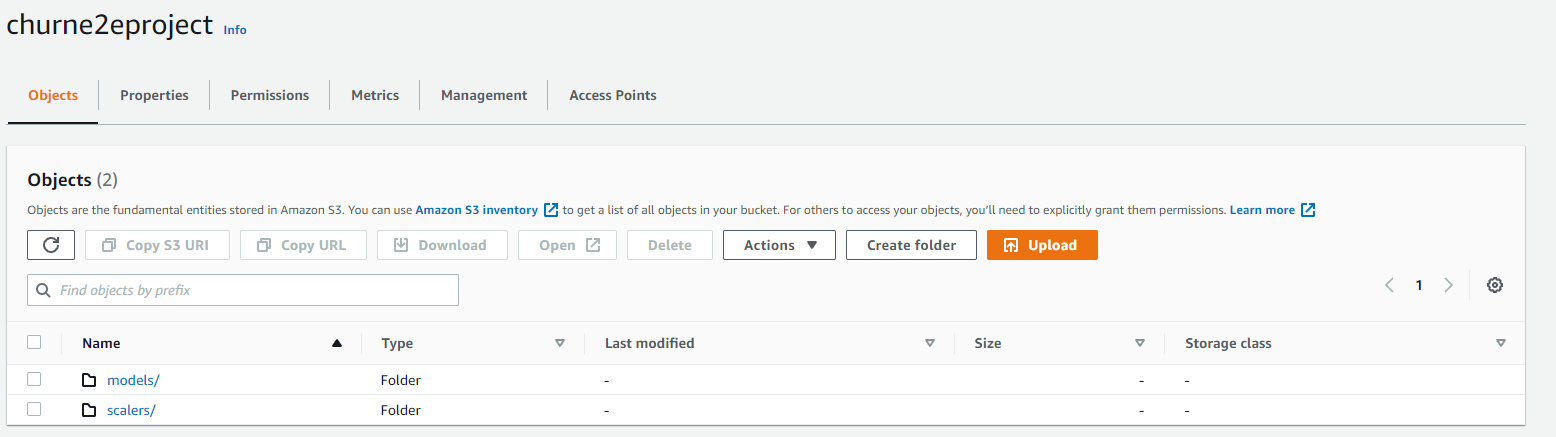

Within the bucket, create two directories - `models` and `scalers` - and upload the `model.pickle` and `scaler.pickle` files to their respective folders.

Now that these files are saved on S3, our API can load them into memory for use on the backend.

## Flask API

Next, we create the Flask API which interfaces with S3 and makes predictions. First, we define some variables that will be necessary later. Replace the strings in angled brackets `<>` with the values you copied from the AWS steps.

In [ ]:
import boto3
from flask import Flask
from flask import request
from flask import json
import pandas as pd
import pickle
from flask_cors import CORS

SECRET = '<YOUR_SECRET_KEY>'
PUBLIC = '<YOUR_PUBLIC_KEY>'

BUCKET_NAME = '<YOUR_BUCKET_NAME>'

MODEL_FILE_NAME = 'model.pickle'
MODEL_LOCAL_PATH = 'models/' + MODEL_FILE_NAME

SCALER_FILE_NAME = 'scaler.pickle'
SCALER_LOCAL_PATH = 'scalers/' + SCALER_FILE_NAME


pand_cols = ['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

nb_cat_labels = {'MultipleLines':3,
 'InternetService':3,
 'OnlineSecurity':3,
 'OnlineBackup':3,
 'DeviceProtection':3,
 'TechSupport':3,
 'StreamingTV':3,
 'StreamingMovies':3,
 'PaymentMethod':4}

Next we create the application itself and enable Cross-Origin Resource Sharing (CORS). CORS is necessary to allow our frontend and backend to interact appropriately [(documentation)](https://developer.mozilla.org/en-US/docs/Web/HTTP/CORS).

We then define our endpoint which will be called by our frontend. The frontend will send features via JSON in a POST request, and receive a prediction in the response. Our function simply properly processes the data to get it into the form that our prediction model expects, loads the model, makes the prediction, and returns it as JSON.

In [ ]:
app = Flask(__name__)
CORS(app)

@app.route('/', methods=["POST"])
def index():
  payload = json.loads(request.get_data().decode("utf-8"))
  payload = payload["payload"]
  
  # Convert from strings to floats (should we convert the ints to ints instead?)
  for i in range(len(payload)):
    if i in [4, 17, 18]:
        payload[i] = float(payload[i])
    else:
        payload[i] = int(payload[i])


  # If the age is greater than 65, declare the person a senior citizen
  if payload[1] >= 65:
    payload[1] = 0
  else:
    payload[1] = 1

  # If do not have phone service, set "multiple lines" to the proper feature
  if payload[5] == 0:
    payload[6] = 1

  # If do not have internet, set relevant params to proper features
  if payload[7] == 2:
    payload[8] = 1
    payload[9] = 1
    payload[10] = 1
    payload[11] = 1
    payload[12] = 1
    payload[13] = 1

  # Create a pandas dataframe from the list
  df = pd.DataFrame([payload], columns=pand_cols)

  # One hot the pandas dataframe
  for elt in list(nb_cat_labels.keys()):
    # Index of column to be one hotted
    i = df.columns.get_loc(elt)

    # Create list that holds one-hotted variable
    new_df = [0 for i in range(nb_cat_labels[elt])]
    new_df[df[elt][0]] = 1

    # Create column names for the new dataframe
    new_cols = [elt+'_'+str(i) for i in range(nb_cat_labels[elt])]

    # Create a new df of elt one-hotted
    new_df = pd.DataFrame([new_df], columns=new_cols)

    # Drop elt from the df
    df = df.drop(columns=[elt])

    # Add each column of the new_df in place of elt
    for j in new_df:
        df.insert(loc=i, column=j, value=new_df[j])
        i += 1  # Could also add in reverse order to avoid iterating i

  # Add the engineered features
  df['MonthlyCharges_sq'] = df['MonthlyCharges']**2
  df['MonthlyTenureInteraction'] = df['MonthlyCharges']*df['tenure']

  # Scale the numerical features within the dataframe
  df = scale_df(df)

  # Create the prediction
  prediction = int(load_model().predict(df)[0])

  # Convert prediction to string so we can easily display it on the front end
  if prediction == 0:
    prediction = "This person is not likely to churn"
  else:
    prediction = "This person is likely to churn"
  data = {}
  data["data"] = prediction

  return json.dumps(data)

Finally, we add the helper functions which aid the above function. Note that we need our IAM public and private access keys here for authentication to access our S3 bucket. At the end, we run the app at the specified port if this file is run as a main file.

In [ ]:
# Loading our model from S3
def load_model():
  s3 = boto3.resource('s3',
         aws_access_key_id=PUBLIC,
         aws_secret_access_key= SECRET
         )
  my_pickle = pickle.loads(s3.Bucket(BUCKET_NAME).Object(MODEL_LOCAL_PATH).get()['Body'].read())
  return my_pickle

# Loading scaler from S3
def load_scaler():
  s3 = boto3.resource('s3',
         aws_access_key_id=PUBLIC,
         aws_secret_access_key= SECRET
         )
  my_pickle = pickle.loads(s3.Bucket(BUCKET_NAME).Object(SCALER_LOCAL_PATH).get()['Body'].read())
  return my_pickle


# Function for scaling the numerical features of the prediction dataframe
def scale_df(df):
  numer = ["tenure", "MonthlyCharges", "TotalCharges", "MonthlyCharges_sq", "MonthlyTenureInteraction"]

  scaler = load_scaler()

  df[numer] = pd.DataFrame(scaler.transform(df[numer]), columns=numer)

  return df

if __name__ == "__main__":
  app.run(host="127.0.0.1", port=5000)

## Testing the API Locally

Next, we want to test the API locally to ensure that it is behaving appropriately. For this we use [cURL](https://en.wikipedia.org/wiki/CURL). 

First, in a command prompt, navigate into the directory which houses your flask api, here called `flask_api.py`.

Next, create an environment variable to tell Flask which file to execute

In [ ]:
set FLASK_APP=flask_api.py

Then run the app, making sure you are in a development environment with the required packages before you do.

In [ ]:
flask run

Now the flask application is running at `http://127.0.0.1:5000`.

To test the API, run the following in **another** cmd (obviously leaving the previous one open). It will send

In [ ]:
curl -d "{\"payload\": [1,0,0,0,24,1,0,0,0,2,0,0,0,0,0,1,3,49.7,1218.25]}" http://127.0.0.1:5000/

You should see the response

In [ ]:
{"data": "This person is not likely to churn"}

(or possibly that this person is likely to churn if your model mislabels). The sent data corresponds to:

| Feature | Numerical Value | Text Value (if applicable) |
| --------------- | --------------- | --------------- |
| gender | 1 | Male |
| SeniorCitizen | 0 | No |
| Partner | 0 | No |
| Dependents | 0 | No |
| tenure | 24 |  |
| PhoneService | 1 | Yes |
| MultipleLines | 0 | No |
| InternetService | 0 | DSL |
| OnlineSecurity | 0 | No |
| OnlineBackup | 2 | Yes |
| DeviceProtection | 0 | No |
| TechSupport | 0 | No |
| StreamingTV | 0 | No |
| StreamingMovies | 0 | No |
| Contract | 0 | Month-to-Month |
| PaperlessBilling | 1 | Yes |
| PaymentMethod | 3 | Electronic Check |
| MonthlyCharges | 49.7 |  |
| TotalCharges | 1218.25 |  |

## Deploying to PythonAnywhere

We will use [https://www.pythonanywhere.com/](PythonAnywhere) to host the API. Sign up for a free account and create a new web app from your `flask_api.py`. Your API is accessible at `https://<YOUR_USERNAME>.pythonanywhere.com`. Make sure that you download your required packages in a bash console for the version of Python that you're using (e.g. `pip3.7 install flask_cors`)

Test a successful deployment by again using cURL:

In [ ]:
curl -d "{\"payload\": [1,0,0,0,24,1,0,0,0,2,0,0,0,0,0,1,3,49.7,1218.25]}" https://<YOUR_USERNAME>.pythonanywhere.com/

**Note the extra final slash at the end of the address in the cURL command**. This is necessary given that we make `/` the endpoint to our prediction function in the api.

You should receive the same response as when you tested locally.

# 9) Deployment - Frontend

We will use React to create the frontend using [create-react-app](https://create-react-app.dev/). Ensure that you have `npm` installed before doing this.

Going over all of the files in the React application folder would be uninformative; but for those interested, you can look through the code [here](https://github.com/oconnoob/churn_frontend).

For those who simply would like to finish this project, clone this repo. The only change you need to make is going into `InputForm.js` and changing the `fetch` address for in the POST request to `https://<YOUR_USERNAME>.pythonanywhere.com/`.

Finally, open a command prompt and `cd` into the  `app` folder. `npm start` allows you to run the application locally. 

Finally, run `npm build`. This will build an efficient version of the react app.

(N.B. if you are using a proxy "http://127.0.0.1:5000" in `package.json` for local testing, delete this before building) 

## Deploy using Netlify

Finally, we will deploy the application using [Netlify](https://www.netlify.com/). Create a new site and then drag and drop your `build` folder to deploy the application. Your site will have a name like `https://<ADJECTIVE>-<FAMOUS_MATHEMATICIAN>-<RANDOM_NUMBER>.netlify.app/` - this is where your frontend is hosted. If you own a domain, you can connect it.

That's it! Now you can use this application to input customer information to see if it is likely or unlikely that s/he will churn in the next month.

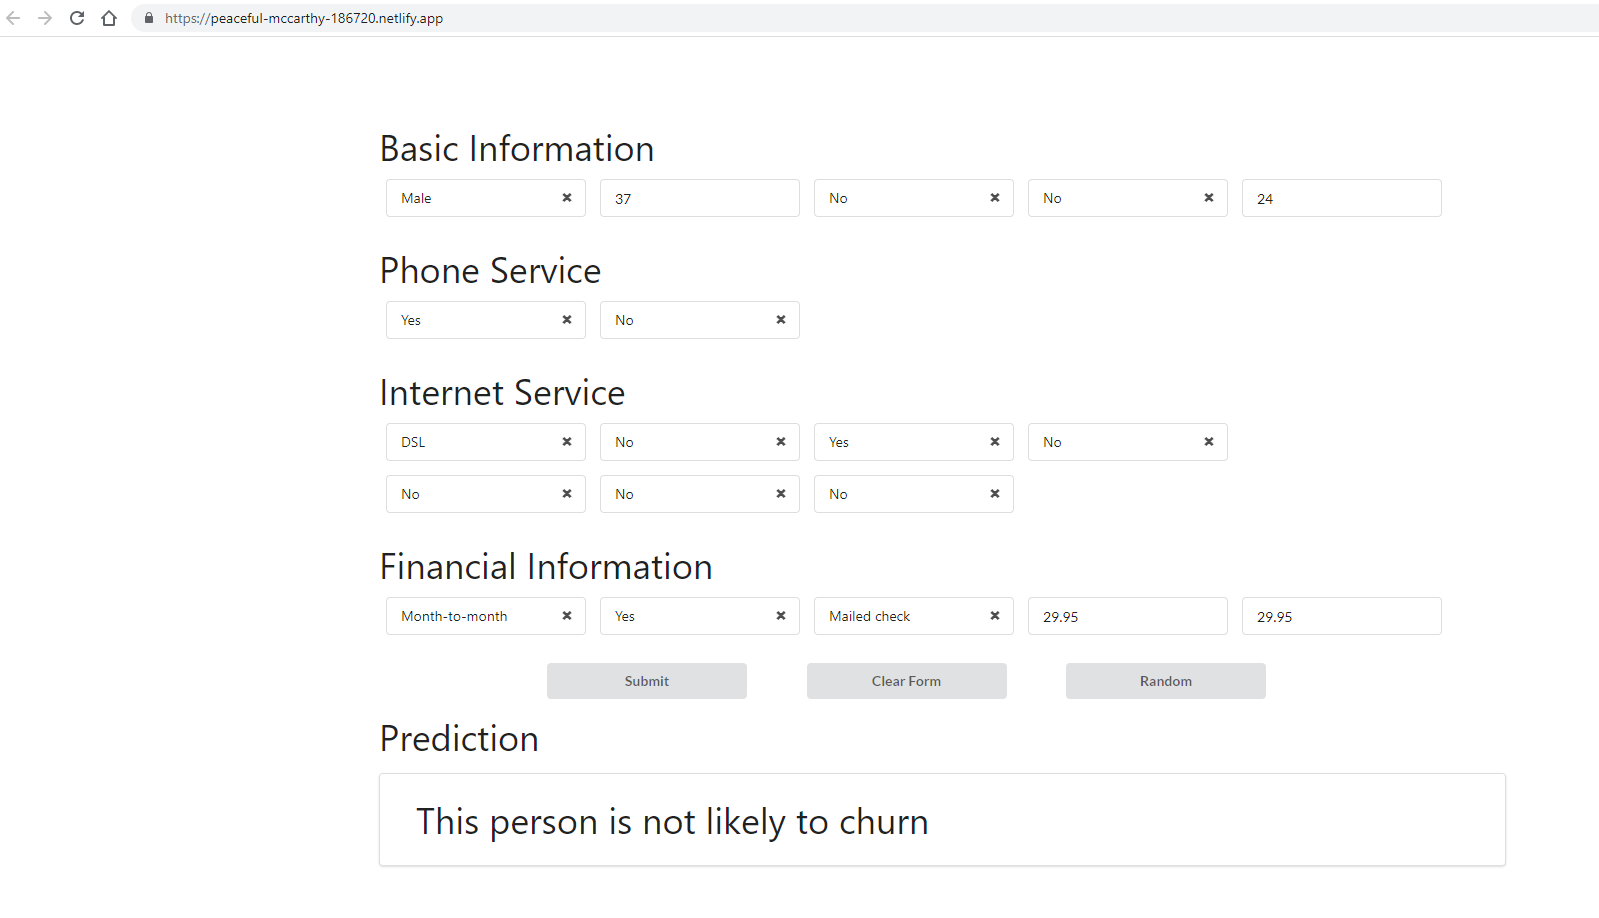

(N.B. if you want to do continuous deployment, you can link a repo. Make the source folder `app`, the build command `npm run build`, and the build folder `app\build`)

# 10) Monitoring & Optimization

Given that this was just a small example project, nothing else needs to be done. If this were a real deployment, we could monitor our model and update it with new models, either simply trained with more data or new features, continuously. Deploying some models in ghost mode to monitor their relative performance, or splitting traffic to run A/B tests to try to optimize the retention to cost ratio are other options.